<H3> Some Notes (Ignore) </H3>
<p> Every Python variable as a pointer to an object. When we pass a variable to a function, the variable (pointer) within the function is always a copy of the variable (pointer) that was passed in. So if we assign something new to the internal variable, all we are doing is changing the local variable to point to a different object. This doesn't alter (mutate) the original object that the variable pointed to, nor does it make the external variable point to the new object. At this point, the external variable still points to the original object, but the internal variable points to a new object. If we want to alter the original object (only possible with mutable data types), we have to do something that alters the object without assigning a completely new value to the local variable.</p>

<H3> Init </H3>

In [19]:
%reload_ext autoreload
%autoreload 2
#ignore warnings.
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<H3> Imports and Constants </H3>

In [20]:
#imports
import pandas as pd
import numpy as np
import os, sys, itertools as it, random
import datetime as dt
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score, recall_score, balanced_accuracy_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss, roc_curve, brier_score_loss

#path
sys.path.append('../modules')

<H3> File Configurations </H3>

In [21]:
def load_configurations():
    #configurations of prediction file [column header, format, range etc.]
    c_p={
            'dir': '../newdata/predictions/',
            'file': 'predictions.csv',
            'number_of_samples': 500, #don't bother about this, this is just used while generating synthetic data
            'id_column': 'person_id',
            'date_column': 'Date',
            'date_format': 'ym', #options: 'ym', 'y-m-d', datetime
            'start_date': '2016-01-01', #first month is January 2016
            'end_date': '2018-01-01', #last month is December 2017
            'model_columns': ['lin_reg', 'rand_forest', 'xg_boost', 'sgmm']
        }

    #configurations of referral file [column header, format, range etc.]
    c_r={
            'dir': '../newdata/referrals/',
            'file': 'referrals.csv',
            'number_of_samples': 25, #don't bother about this, this is just used while generating synthetic data
            'start_date': '2016-01-01',
            'end_date': '2018-01-01',
            'id_column': 'person_id',
            'date_column': 'Date',
            'date_format': 'datetime', #options: 'ym', 'y-m-d', datetime
            'day_to_evaluate': 1 #evaluate on day 1 of each month
        }
    
    #configurations for the experiment
    c_e={
            'experiment': 'Version 1.0',
            'dir': '../newdata/results/',
            'file': 'results.csv',
            'thresholding': [0.5, 0.6],
            'top_k': [50,60],
            'window': [[-3,6], [0,3], [0,6], [0,12]],
            'eval_date': pd.to_datetime(dt.date(2017,1,1)),
            'recent_ref_window': 6,
            'plot_metrics' : ['precision', 'recall', 'accuracy', 'balanced_acc', 'f1_score', 'log_loss', 'roc_auc_score', 'brier_score_loss'],
            'plot_window' : [[0,3], [0,6]],
            'eval_method': 'top_k' #options: 'top_k' or 'thresholding'
        }
    
    return c_p, c_r, c_e

<H3> HELPER FUNCTIONS </H3>

In [22]:
#for generation
#generate random date between a range
#input in datetime.date format
#mutable obj integrity checked
def generate_random_date(start_date, end_date, iteration, date_format):
    date_list = []
    seed = 0
    for i in range(iteration):
        s_date = datetime.strptime(start_date, '%Y-%m-%d')
        e_date = datetime.strptime(end_date, '%Y-%m-%d')
        time_between_dates = e_date - s_date
        days_between_dates = time_between_dates.days
        random.seed(seed)
        random_number_of_days = random.randrange(days_between_dates)
        random_date = s_date + dt.timedelta(days=random_number_of_days) #this is datetime object
        if date_format=='y-m-d':
            random_date = random_date.strftime('%Y-%m-%d') #string format output
        elif date_format=='ym':
            random_date = int(random_date.strftime("%Y%m"))
        date_list.append(random_date)
        seed += 1
    
    return date_list

In [23]:
#for evaluation
#preprocess referral dates
#convert any day in any month to the first day of that month in REFERRAL data
#mutable obj integrity checked
#ref_copy passed by reference, changed directly
def convert_dates_ref(ref_copy, c_r): #use if c_r['date_format'] is 'y-m-d' or datetime
    ref_date_column = ref_copy[c_r['date_column']]
    for i in range(len(ref_date_column)):
        formatted_date = ref_date_column[i]
        new_formatted_date = datetime(formatted_date.year, formatted_date.month, c_r['day_to_evaluate'])
        ref_copy.at[i,c_r['date_column']] = new_formatted_date


In [24]:
#for evaluation
#convert top k probability of a target to 1, O/W to 0 mapping
#target was a pd.series, kept intact
#mutable obj integrity checked
def prob_to_bin(target, k):
    target_bin = target.copy()
    target_bin[target_bin.index] = 0
    idx = target.nlargest(k).index
    target_bin[idx] = 1

    return target_bin
#return local variable, it does not get lost, stays in heap as long as there is a reference to it. O/W garbage collector.

In [25]:
#for evaluation
'''
pd.to_Datetime(anything) = create datetime object
datetime.strptime(string) -> datetime object
datetime.strftime(datetime) -> string in different formats
'''
#give a 'ym' column, it will convert all of them to datetime
#mutable obj integrity checked
#updated mutable dataframe passed by reference
def ym_to_datetime(config, df): #ym to datetime
    label = config['date_column']
    df[label] = df[label].astype(str)
    for i in range(df[label].size):
        df[label][i] = df[label][i][:4] + '-' + df[label][i][4:] + '-01' #choosing the first month of the day
    df[label] = pd.to_datetime(df[label])
    #return df
    

In [26]:
#for evaluation
def drop_recent_referrals(c_p, c_r, c_e, ref_copy, pred_copy):
    start = c_e['eval_date'] - pd.DateOffset(months=c_e['recent_ref_window'])
    end = c_e['eval_date'] - pd.DateOffset(months=1) #ends the previous month of the current month
    mask = (ref_copy[c_r['date_column']]>=start) & (ref_copy[c_r['date_column']]<=end)
    
    #those IDs from prediction (0-500) that are not in list of those IDs that fall in daterange of all IDs(0-1000)
    idx = ~pred_copy[c_p['id_column']].isin(ref_copy.loc[mask][c_r['id_column']])
    pred_copy = pred_copy[idx]
    return pred_copy


In [27]:
#[0,3] -> datetime range in string
def window_to_range(c_e, window):
    
    if(window[0]<0):
        start = c_e['eval_date'] - pd.DateOffset(months=(-1)*window[0])
    else:
        start = c_e['eval_date'] + pd.DateOffset(months=window[0])

    end = c_e['eval_date'] + pd.DateOffset(months=window[1])
    
    start = start.strftime('%Y/%m')
    end = end.strftime('%Y/%m')
    
    win_range = start + '-' + end
    return win_range

<H3> Generate Synthetic Data </H3>

In [28]:
#for generaiton
#mutable obj integrity checked
#no changes in c_p, c_r
def generate_synthetic_ground_truth_data(c_p, c_r):
    seed = 1234
    np.random.seed(seed)
    patients = pd.Series([x for x in np.random.randint(0, c_p['number_of_samples']*2, c_r['number_of_samples'])])
    patients = patients.sort_values(ascending=True).reset_index(drop=True)
    date = pd.Series([d for d in generate_random_date(c_r['start_date'], c_r['end_date'], c_r['number_of_samples'], c_r['date_format'])])
    data = pd.DataFrame({c_r['id_column']:patients, c_r['date_column']:date})
    #dataframe_to_csv(data, c_r['dir']+c_r['file'])
    data.to_csv(c_r['dir']+c_r['file'], index = False, float_format= '%8.5f', mode='w')


In [29]:
#for generation
#mutable obj integrity checked
#no changes in c_p
def generate_synthetic_prediction_data(c_p):
    patients = pd.Series(range(0, c_p['number_of_samples'])) #500
    
    if c_p['date_format']=='ym':
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS').strftime("%Y%m").astype(int) #25
    elif c_p['date_format']=='y-m-d':
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS').strftime("%Y-%m-%d")
    else:
        date = pd.date_range(c_p['start_date'], c_p['end_date'], freq='MS')
    
    data = pd.DataFrame(list(it.product(patients,date)),columns=[c_p['id_column'],c_p['date_column']])
    seed = 1234
    for model in c_p['model_columns']:
        np.random.seed(seed)
        data[model] = pd.Series(np.random.random((data.shape[0])))
        seed+=1
    
    #dataframe_to_csv(data, c_p['dir']+c_p['file'])
    data.to_csv(c_p['dir']+c_p['file'], index=False, float_format= '%8.5f', mode='w')
    

<H3> Score Class </H3>

In [30]:
#for evaluation
class Score:
    
    def __init__(self, model_name):
        self.model_name = model_name
        self.experimental_samples = -1
        self.precision = {}
        self.recall = {}
        self.accuracy = {}
        self.balanced_acc = {}
        self.f1_score = {}
        self.roc_auc_score = {} 
        self.log_loss = {}
        self.brier_score_loss = {}
    
    def get_precision(self, y_true, y_predict, average='binary'):
        return precision_score(y_true, y_predict, average)
    
    def get_recall(self, y_true, y_predict, average='binary'):
        return recall_score(y_true, y_predict, average)
    
    def get_accuracy(self, y_true, y_predict):
        return recall_score(y_true, y_predict)
    
    def get_balanced_acc(self, y_true, y_predict):
        return balanced_accuracy_score(y_true, y_predict)
    
    def get_f1_score(self, y_true, y_predict, average='binary'):
        return f1_score(y_true, y_predict, average='binary')
    
    def get_roc_auc_score(self, y_true, y_predict):
        return roc_auc_score(y_true, y_predict)
    
    def get_log_loss(self, y_true, y_predict):
        return log_loss(y_true, y_predict)

    def get_brier_score_loss(self, y_true, y_predict):
        return brier_score_loss(y_true, y_predict)
    
        

<H3> Evaluation </H3>

In [31]:
#cp, c_r, c_e are all mutable
#mutable obj integrity checked
def evaluate(c_p, c_r, c_e, drop_ref = True, drop_neg_prob = True):
    
    eval_method = c_e['eval_method']      
    
    referral = pd.read_csv(c_r['dir'] + c_r['file'])
    ref_copy = referral.copy() #shallow copy
    
    #convert_dates_ref(c_r)
    if c_r['date_format']=='ym':
        ym_to_datetime(c_r, ref_copy) #passing reference of mutable ref_copy, will be directly edited
    else:
        ref_copy[c_r['date_column']] = pd.to_datetime(ref_copy[c_r['date_column']])
        convert_dates_ref(ref_copy, c_r)
    
    #now both pred_copy['Date'] and ref_copy['Date'] is in Datetime format instead of previous String format
    
    prediction = pd.read_csv(c_p['dir'] + c_p['file'])
    pred_copy = prediction.copy()
        
    #change date from ym to ymd here
    if c_p['date_format']=='ym':
        ym_to_datetime(c_p, pred_copy) #passing reference of mutable pred_copy, will be directly edited
    else:
        pred_copy[c_p['date_column']] = pd.to_datetime(pred_copy[c_p['date_column']])
        
    #now both ref_copy and pred_copy are datetime
    ##only applying top_k in selected range, not the whole column-------------------->>>>>>>
    pred_copy = pred_copy.loc[pred_copy[c_p['date_column']]==c_e['eval_date']] 
    
    all_model_list = c_p['model_columns']
    
    #if all models predicts -1, then I can safely drop patient-month-date row with -1 predictions here
    #select rows, where the first model is not -1 (all model predicts -1)
    if drop_neg_prob == True:
        pred_copy = pred_copy[pred_copy[all_model_list[0]]!=-1]
    
    #remove recent referrals checking back k months in referral and drop them from prediction
    if drop_ref == True:
        pred_copy = drop_recent_referrals(c_p, c_r, c_e, ref_copy, pred_copy)
    
    #pivot referral table
    ref_copy['target'] = pd.Series(np.ones(ref_copy.shape[0], dtype=float))
    ref_copy = ref_copy.pivot_table(index=c_r['id_column'], columns=c_r['date_column'], values='target', aggfunc='sum')
    ref_copy = ref_copy.fillna(0)
    
    all_model_evaluations = {} #{'model_name':score class object for that model}
        
    #now branch out for each model
    for model in all_model_list:
        
        evaluated_model_obj = Score(model)
        
        #calculate for each window
        for window in c_e['window']:
            
            #taking negative window into consideration
            if(window[0]<0):
                start = c_e['eval_date'] - pd.DateOffset(months=(-1)*window[0])
            else:
                start = c_e['eval_date'] + pd.DateOffset(months=window[0])
                
            end = c_e['eval_date'] + pd.DateOffset(months=window[1])
            
            sl=slice(start,end)
            y_true = ref_copy.loc[:,sl] #also a shallow copy
            
            #aggregate referrals
            y_true = y_true.sum(axis=1)
            
            #aggregated referral map to 1 if >1
            y_true[y_true>1] = 1
            
            #for the time being, all ref patients are in pred_list. 
            #Change random.randint upper_range in data_generate to tweak
            y_true=y_true[y_true.index.isin(pred_copy[c_p['id_column']])]
            
            y_true=y_true.append(pd.Series(0,index=set(pred_copy[c_p['id_column']])-set(y_true.index))).sort_index()
        
            #their size have to be same -- TO USE the built in metric functions
            if pred_copy.shape[0]!=len(y_true):
                print("ERROR: PREDICTION AND ACTUAL DATAFRAME HAVE DIFFERENT NUMBERS.  PREDICTION:",
                      pred_copy.shape[0], " EVALUATION: ",len(y_true))
                break
            
            #now thresholding method
            if eval_method=='top_k':
                for k_values in c_e['top_k']:
                    label = model+'_window_['+str(window[0])+','+str(window[1])+']_'+eval_method + '_@' + str(k_values)
                    pred_copy[label] = prob_to_bin(pred_copy[model], k_values)
                    #model score for this (window,k) update
                    update_model_score(model, evaluated_model_obj, label, y_true, pred_copy)
    
            elif eval_method == 'thresholding':
                for thresholds in c_e['thresholding']:
                    label = model+'_window_['+str(window[0])+','+str(window[1])+']_'+eval_method + '_@' + str(thresholds)
                    pred_copy[label] = np.where(pred_copy[model] > thresholds, 1, 0)
                    #model score for this (window,threshold) update
                    update_model_score(model, evaluated_model_obj, label, y_true, pred_copy)
            
        all_model_evaluations.update({model:evaluated_model_obj})
    
    return all_model_evaluations

In [32]:
#mutable obj integrity checked
#evaluated_model_obj changed as requirement
def update_model_score(model, evaluated_model_obj, label, y_true, pred_copy):
    
    precision = evaluated_model_obj.get_precision(y_true.values, pred_copy[label].values)
    evaluated_model_obj.precision.update({label:precision})

    recall = evaluated_model_obj.get_recall(y_true.values, pred_copy[label].values)
    evaluated_model_obj.recall.update({label:recall})

    accuracy = evaluated_model_obj.get_accuracy(y_true.values, pred_copy[label].values)
    evaluated_model_obj.accuracy.update({label:accuracy})

    balanced_acc = evaluated_model_obj.get_balanced_acc(y_true.values, pred_copy[label].values)
    evaluated_model_obj.balanced_acc.update({label:balanced_acc})

    f1_score = evaluated_model_obj.get_f1_score(y_true.values, pred_copy[label].values)
    evaluated_model_obj.f1_score.update({label:f1_score})

    #these will take predicted probabilites, not thresholded binaries

    log_loss = evaluated_model_obj.get_log_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.log_loss.update({label:log_loss})

    roc_auc_score = evaluated_model_obj.get_roc_auc_score(y_true.values, pred_copy[model].values)
    evaluated_model_obj.roc_auc_score.update({label:roc_auc_score})
    
    brier_score_loss = evaluated_model_obj.get_brier_score_loss(y_true.values, pred_copy[model].values)
    evaluated_model_obj.brier_score_loss.update({label:brier_score_loss})
    
    #add number of samples used by this model
    evaluated_model_obj.experimental_samples = y_true.shape[0]
    
    

<H3> Present Evaluation </H3>

In [33]:
#generate plottable dataframe from whole result: evaluation_to_dataframe() helper function
#visualize result (if visual==True): visualize_performance() helper_function
#save result to CSV file: Use dataframe_to_csv() helper function
#mutable obj integrity checked
def present_evaluation(cp, c_r, c_e, all_model_evaluations, table=False, plot = False, save=False):
    
    #result file
    result_file = c_e['dir'] + c_e['file']
    
    #clear if there is already any result file previously (from previous run/experiment), 
    #otherwise it will just keep appending, as opening in append mode
    if os.path.exists(result_file):
        os.remove(result_file)
        
    data = generate_tabular_data(c_p, c_r, c_e, all_model_evaluations)
    
    if table == True:
        pd.options.display.float_format = '{:8.5f}'.format
        display(data)
        
    #will add graph here
    if plot == True:
        generate_plot(c_e, data, c_e['plot_window'], c_e['plot_metrics'])
    
    if save == True:
        data.to_csv(result_file, index = False, float_format= '%8.5f', mode='w')
    
    

In [34]:
#takes all info, returns dataframe 
def generate_tabular_data(c_p, c_r, c_e, all_model_evaluations):
    
    data = pd.DataFrame()
    row = 0
    metric_name = ['precision', 'recall', 'accuracy', 'balanced_acc', 'f1_score', 'log_loss', 'roc_auc_score', 'brier_score_loss']
    
    for model in all_model_evaluations:
        for window in c_e['window']:
            sub_key = '['+str(window[0])+','+str(window[1])+']'
            data.loc[row, 'Start Time'] = pd.Timestamp.now(tz=None)
            data.loc[row, 'Experiment Name'] = c_e['experiment']
            data.loc[row, 'Model'] = model
            data.loc[row, 'Window'] = window_to_range(c_e, window)
            data.loc[row, 'Eval Date'] = c_e['eval_date']
            data.loc[row, 'Num Samples'] = all_model_evaluations[model].experimental_samples
            
            #-- change here if both k and thresh needed
            for metric in metric_name:
                values  = [value for key, value in all_model_evaluations[model].__dict__[metric].items() if sub_key in key] #[K_50, K_60..]
                if c_e['eval_method'] == 'top_k':
                    for i in range(len(c_e['top_k'])):
                        col_label = metric + '_@k='+str(c_e['top_k'][i])
                        data.loc[row, col_label] = values[i]
                elif c_e['eval_method'] == 'thresholding':
                    for i in range(len(c_e['thresholding'])):
                        col_label = metric + '_p>'+str(c_e['thresholding'][i])
                        data.loc[row, col_label] = values[i]
            
            #source files
            data.loc[row, 'Prediction Source'] = c_p['dir'] + c_p['file']
            data.loc[row, 'Referral Source'] = c_r['dir'] + c_r['file']
            data.loc[row, 'Result Output'] = c_e['dir'] + c_e['file']
            
            #timestamps
            data.loc[row, 'End Time'] = pd.Timestamp.now(tz=None)
            data.loc[row, 'Total Time'] = data.loc[row, 'End Time'] - data.loc[row, 'Start Time']
            row = row + 1
    
    data['Num Samples'] = data['Num Samples'].astype(int)

    #moving the start time col to end
    cols = data.columns.tolist()
    cols = cols[1:-2] + [cols[0]] + cols[-2:]
    data = data[cols]
    
    return data

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

def generate_plot(c_e, data, plot_window, metrics):
    
    for window in plot_window:
        
        win = window_to_range(c_e, window)
        new_data = data[data['Window']==win]

        for t in c_e[c_e['eval_method']]:
            metric_col = [col for col in new_data.columns if str(t) in col] #original column names for metrics (All 8 metric columns)
            final_original_columns = ['Model']
            final_modified_columns = ['Model']

            for metric_name in metrics:
                final_original_columns = final_original_columns + [col for col in metric_col if metric_name in col] #only columns passed
                final_modified_columns = final_modified_columns + [metric_name for col in metric_col if metric_name in col]

            pf = new_data[final_original_columns].copy()

            for i in range(len(pf.columns)):
                pf.rename(columns={final_original_columns[i]:final_modified_columns[i]}, inplace=True)

            #pivot the data to covert wide dataframe to long dataframe
            pf_new = pd.melt(pf, id_vars=['Model'], value_vars=final_modified_columns[1:])

            data_plot = sns.catplot(x="variable", y="value", hue="Model", data=pf_new, kind="bar", height = 4, aspect = 3)
            data_plot.set_xlabels("Metrics")
            data_plot.set_ylabels("Score")
            title = "Performance of Models During " + win + " with " + c_e['eval_method'] + "_@" + str(t)
            data_plot.fig.suptitle(title)
            data_plot.savefig("output.jpg")

<H2> MAIN </H2>

,Experiment Name,Model,Window,Eval Date,Num Samples,precision_@k=50,precision_@k=60,recall_@k=50,recall_@k=60,accuracy_@k=50,...,roc_auc_score_@k=50,roc_auc_score_@k=60,brier_score_loss_@k=50,brier_score_loss_@k=60,Prediction Source,Referral Source,Result Output,Start Time,End Time,Total Time
0,Version 1.0,lin_reg,2016/10-2017/07,2017-01-01,495,0.02000,0.03333,0.25000,0.50000,0.25000,...,0.52749,0.52749,0.32991,0.32991,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:49.933105920,2020-05-21 01:58:49.956035072,00:00:00.022929
1,Version 1.0,lin_reg,2017/01-2017/04,2017-01-01,495,0.02000,0.03333,0.25000,0.50000,0.25000,...,0.52749,0.52749,0.32991,0.32991,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:49.958029056,2020-05-21 01:58:49.965010944,00:00:00.006981
2,Version 1.0,lin_reg,2017/01-2017/07,2017-01-01,495,0.02000,0.03333,0.25000,0.50000,0.25000,...,0.52749,0.52749,0.32991,0.32991,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:49.966008064,2020-05-21 01:58:49.974983936,00:00:00.008975
3,Version 1.0,lin_reg,2017/01-2018/01,2017-01-01,495,0.02000,0.03333,0.14286,0.28571,0.14286,...,0.59456,0.59456,0.32780,0.32780,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:49.975981056,2020-05-21 01:58:49.982962944,00:00:00.006981
4,Version 1.0,rand_forest,2016/10-2017/07,2017-01-01,495,0.04000,0.03333,0.50000,0.50000,0.50000,...,0.64358,0.64358,0.32953,0.32953,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:49.983960064,2020-05-21 01:58:49.990940928,00:00:00.006980
5,Version 1.0,rand_forest,2017/01-2017/04,2017-01-01,495,0.04000,0.03333,0.50000,0.50000,0.50000,...,0.64358,0.64358,0.32953,0.32953,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:49.991939072,2020-05-21 01:58:49.999425024,00:00:00.007485
6,Version 1.0,rand_forest,2017/01-2017/07,2017-01-01,495,0.04000,0.03333,0.50000,0.50000,0.50000,...,0.64358,0.64358,0.32953,0.32953,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:50.000421888,2020-05-21 01:58:50.008400896,00:00:00.007979
7,Version 1.0,rand_forest,2017/01-2018/01,2017-01-01,495,0.04000,0.03333,0.28571,0.28571,0.28571,...,0.61300,0.61300,0.32879,0.32879,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:50.008400896,2020-05-21 01:58:50.017377024,00:00:00.008976
8,Version 1.0,xg_boost,2016/10-2017/07,2017-01-01,495,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.31976,0.31976,0.34027,0.34027,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:50.018373888,2020-05-21 01:58:50.025355008,00:00:00.006981
9,Version 1.0,xg_boost,2017/01-2017/04,2017-01-01,495,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.31976,0.31976,0.34027,0.34027,../newdata/predictions/predictions.csv,../newdata/referrals/referrals.csv,../newdata/results/results.csv,2020-05-21 01:58:50.026352896,2020-05-21 01:58:50.035329024,00:00:00.008976


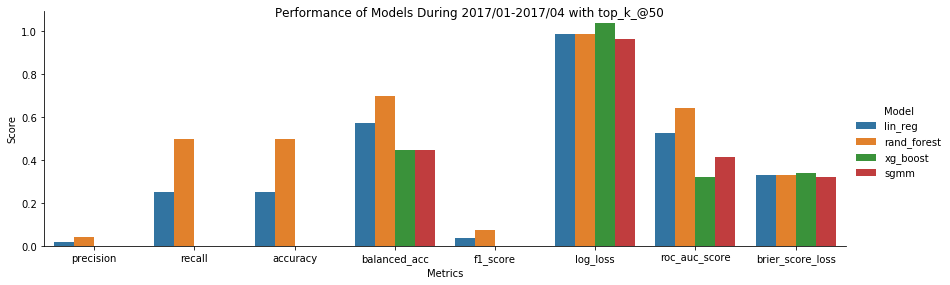

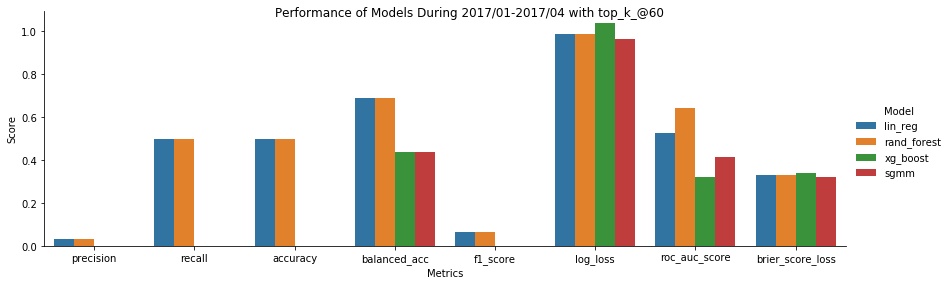

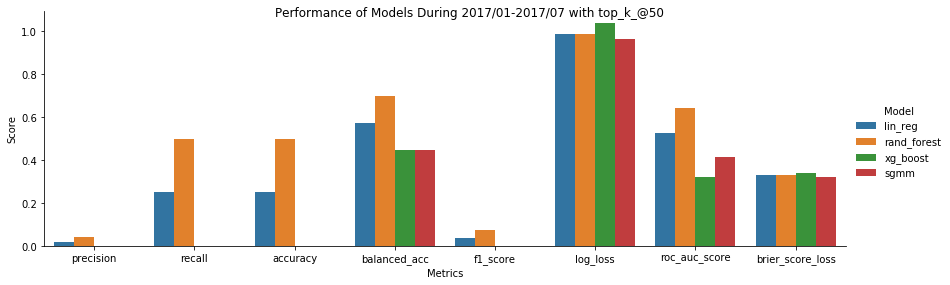

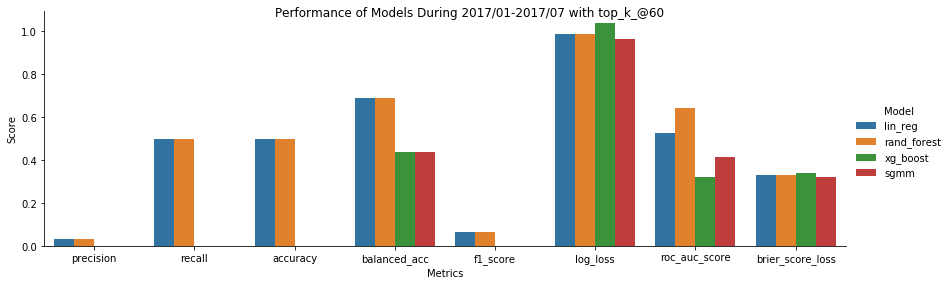

In [36]:
pd.set_option('display.max_rows', None) #to show all the rows of a dataframe
if __name__ == "__main__":
    c_p, c_r, c_e = load_configurations()
    generate_synthetic_ground_truth_data(c_p, c_r)
    generate_synthetic_prediction_data(c_p)
    all_model_evaluations = evaluate(c_p, c_r, c_e, drop_ref = True, drop_neg_prob = True) #neg window can be controlled from config
    
    '''
    keep visual=True if you want to see data + plots
    keep save=True if you want to save the data into a CSV file
    '''
    present_evaluation(c_p, c_r, c_e, all_model_evaluations, table=True, plot = True, save=True)
    